# import packages

In [1]:
import logging
import sys

import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

from astropy.io import fits
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

In [2]:
from rascil2.data_models import (
    PolarisationFrame,
    import_skycomponent_from_hdf5,
    export_skycomponent_to_hdf5,
)

from rascil2.processing_components.skycomponent.operations import (
    create_skycomponent,
    find_skycomponent_matches
)

from rascil2.processing_components.image.operations import (
    import_image_from_fits
)



# rascil logger

In [3]:
log = logging.getLogger("rascil-logger")
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

In [4]:
def init_logging():
    logging.basicConfig(
        filename=logfile,
        filemode="a",
        format="%(asctime)s.%(msecs)d %(name)s %(levelname)s %(message)s",
        datefmt="%d/%m/%Y %I:%M:%S %p",
        level=logging.INFO,
    )
logfile = 'comparison_source_finders_SKA.log'
init_logging()

# take Data-ID 1-2 as a example

## read the data from restored image

In [5]:
# the 0th restored image
input_image_restored = './data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.fits'

In [6]:
im = import_image_from_fits(input_image_restored)
im_head = fits.getheader(input_image_restored)
phasecentre = im.image_acc.phasecentre

nchan = im["pixels"].shape[0]
if nchan == 1:
    log.info("This is a single channel image.")
    freq = np.array([im.frequency.data[0]])

elif nchan > 1:
    log.info("This is a multiple channel image.")
    freq = np.array(im.frequency.data)

image_pol = im._polarisation_frame

img_size = np.rad2deg(im.image_acc.wcs.wcs.cdelt[1])

log.info("Frequencies of image:{} ".format(freq))
log.info("Image polarisation frame is: {}".format(image_pol))

This is a single channel image.
Frequencies of image:[81600000.] 
Image polarisation frame is: stokesI


## read skycomponents within the FOV from reference catalogue

In [7]:
def read_skycomponent_from_txt(filename, freq, pol=PolarisationFrame("stokesI")):
    """
    Read source input from a txt file and make them into skycomponents

    :param filename: Name of input file
    :param freq: List of frequencies in float
    :param pol: Polarisation frame
    :return comp: List of skycomponents
    
    """

    data = np.loadtxt(filename, delimiter=",", unpack=True)
    comps = []

    ra = data[0]
    dec = data[1]
    flux = data[2]
    ref_freq = data[6]
    spec_indx = data[7]

    nchan = len(freq)
    npol = pol.npol
    for i, row in enumerate(ra):

        direc = SkyCoord(
            ra=ra[i] * u.deg, dec=dec[i] * u.deg, frame="icrs", equinox="J2000"
        )
        if nchan == 1:
            flux_single = flux[i] * (freq[0] / ref_freq[i]) ** spec_indx[i]
            flux_array = np.array([[flux_single]])
        else:
            if ref_freq[i] > 0:
                fluxes = [flux[i] * (f / ref_freq[i]) ** spec_indx[i] for f in freq]
                flux_array = np.reshape(np.array(fluxes), (nchan, npol))

        comps.append(
            create_skycomponent(
                direction=direc,
                flux=flux_array,
                frequency=freq,
                polarisation_frame=pol,
            )
        )

    return comps

In [8]:
# select the skycomponets within the FOV 
def crop_skycomponent(comps, input_restoreds):
    """
    select skycomponents within the FOV of the input image

    :param comps: list of sky components
    :param input_restoreds: list of input images

    :retrun orig_fileterd: new components list within the FOV
    
    """

    orig_fileterd = []

    for restored in input_restoreds:
        head = fits.getheader(restored)
        w = WCS(head)
        ra_pixel_min = 0
        ra_pixel_max = head["NAXIS1"]
        dec_pixel_min = 0
        dec_pixel_max = head["NAXIS2"]
        
        
        # get the boundaries of the FOV
        ra_dec_min = pixel_to_skycoord(ra_pixel_min, dec_pixel_min, w)
        ra_dec_max = pixel_to_skycoord(ra_pixel_max, dec_pixel_max, w)

        ra_left = ra_dec_min.ra
        ra_right = ra_dec_max.ra
        dec_min = ra_dec_min.dec
        dec_max = ra_dec_max.dec

        if ra_left > 180 * u.degree:
            ra_left = ra_left - 360 * u.degree
        if ra_left < -180 * u.degree:
                ra_left = 360 * u.degree + ra

        if ra_right > 180 * u.degree:
            ra_right = ra_right - 360 * u.degree
        if ra_left < -180 * u.degree:
                ra_left = 360 * u.degree + ra

        ra_min = min(ra_left, ra_right)
        ra_max = max(ra_left, ra_right)

        # make a selection on skycomponents
        for comp in comps:
            ra = comp.direction.ra
            # 角度变换
            if ra > 180 * u.degree:
                ra = ra - 360 * u.degree
            if ra < -180 * u.degree:
                ra = 360 * u.degree + ra

            dec = comp.direction.dec

            if ra >= ra_min and ra <= ra_max and dec >= dec_min and dec <= dec_max:
                orig_fileterd.append(comp)

        log.info("the num of filtered in{}:{} ".format(restored, len(orig_fileterd)))
        
    return orig_fileterd

In [9]:
input_source_filename = "./data/SKADP-39_filed7_GLEAM_random_refcatalogue.txt"
origs = read_skycomponent_from_txt(input_source_filename, freq, pol=PolarisationFrame(image_pol))

origs_crop = crop_skycomponent(origs, [input_image_restored])

the num of filtered in./data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.fits:4349 


## read skycomponents from catalogues of source finders

### functions of reading sky components from catalogues

In [10]:
# catalogue of aegean
def create_aegean_source_to_skycomponent(
        source_file, rascil_source_file, freq, pol=PolarisationFrame("stokesI")
):
    """
    Put the sources into RASCIL2-readable skycomponents from aegean output catalogue with the aegean format

    :param source_file: Output file name of the source list
    :param rascil_source_file: Output file name of the RASCIL2 skycomponents hdf file
    :param freq: List of frequencies in float
                 (if single frequency, pass it in a length one array)
    :param pol: Polarisation frame
    :return comp: List of skycomponents
    
    """

    nchan = len(freq)
    npol = pol.npol
    centre = nchan // 2
    log.info(f" nchan = {nchan}, npol = {npol}")

    data = pd.read_csv(source_file, sep=r'\s*\ ', skiprows=2, engine="python")

    data = data.drop(index=0)  # drop units row

    data = data.drop(index=1)  # drop separation line row

    # skycomps
    comps = []

    for i, row in data.iterrows():

        direc = SkyCoord(
            ra=row["RA.1"], dec=row["DEC.1"], unit=(u.deg, u.deg), frame="icrs", equinox="J2000"
        )

        f0 = float(row["Peak"])

        if f0 > 0:  # filter out ghost sources
            try:
                spec_indx = row["Spec_Indx"]
                fluxes = [f0 * (f / freq[centre]) ** spec_indx for f in freq]
                flux_array = np.reshape(np.array(fluxes), (nchan, npol))

            except KeyError:
                # No spectral index information
                flux_array = np.array([[f0]])

            comps.append(
                create_skycomponent(
                    direction=direc,
                    flux=flux_array,
                    frequency=freq,
                    polarisation_frame=pol,
                )
            )

    log.info("the number of aegean comps:{}".format(len(comps)))
    
#     export_skycomponent_to_hdf5(comps, rascil_source_file)

    return comps

In [11]:
# catalogue of caesar
def create_caesar_source_to_skycomponent(
        source_file, rascil_source_file, freq, pol=PolarisationFrame("stokesI")
):
    """
    Put the sources into RASCIL2-readable skycomponents from caesar output catalogue with the dat format

    :param source_file: Output file name of the source list
    :param rascil_source_file: Output file name of the RASCIL2 skycomponents hdf file
    :param freq: List of frequencies in float
                 (if single frequency, pass it in a length one array)
    :param pol: Polarisation frame
    :return comp: List of skycomponents
    
    """
    
    nchan = len(freq)
    npol = pol.npol
    centre = nchan // 2
    log.info(f" nchan = {nchan}, npol = {npol}")
    
    with open(source_file) as f:
        for i in range(42):
            next(f)
        columns_line = next(f).strip()

    columns = columns_line.lstrip('#').split()
    f.close()
    
    data = pd.read_table(source_file, delimiter='\s+', skiprows=43, names=columns)
    
    comps = []
    
    for i, row in data.iterrows():

        direc = SkyCoord(
            ra=row['x_wcs(deg)'], dec=row['y_wcs(deg)'], unit=(u.deg, u.deg), frame="icrs", equinox="J2000"
        )

        f0 = float(row["Smax(Jy/beam)"])
        
        if f0 > 0:  # filter out ghost sources
            try:
                spec_indx = row["Spec_Indx"]
                fluxes = [f0 * (f / freq[centre]) ** spec_indx for f in freq]
                flux_array = np.reshape(np.array(fluxes), (nchan, npol))

            except KeyError:
                # No spectral index information
                flux_array = np.array([[f0]])

        if f0 > 0:  # filter out ghost sources
            flux_array = np.array([[f0]])

        comps.append(
            create_skycomponent(
                direction=direc,
                flux=flux_array,
                frequency=freq,
                polarisation_frame=pol,
            ) )
        
    log.info("the number of caesar comps:{}".format(len(comps))) 
#     export_skycomponent_to_hdf5(comps, rascil_source_file)
    
    return comps

In [12]:
def create_pybdsf_source_to_skycomponent(
    source_file, rascil_source_file, freq, pol=PolarisationFrame("stokesI")
):
    """
    Put the sources into RASCIL2-readable skycomponents from pybdsf output catalogue with the csv format

    :param source_file: Output file name of the source list
    :param rascil_source_file: Output file name of the RASCIL2 skycomponents hdf file
    :param freq: List of frequencies in float
                 (if single frequency, pass it in a length one array)
    :param pol: Polarisation frame
    :return comp: List of skycomponents
    
    """

    data = pd.read_csv(source_file, sep=r"\s*,\s*", skiprows=5, engine="python")
    comps = []

    nchan = len(freq)
    npol = pol.npol
    centre = nchan // 2
    log.info(f" nchan = {nchan}, npol = {npol}")

    for i, row in data.iterrows():

        direc = SkyCoord(
            ra=row["RA"] * u.deg, dec=row["DEC"] * u.deg, frame="icrs", equinox="J2000"
        )
        f0 = row["Peak_flux"]
        if f0 > 0:  # filter out ghost sources
            try:
                spec_indx = row["Spec_Indx"]
                fluxes = [f0 * (f / freq[centre]) ** spec_indx for f in freq]
                flux_array = np.reshape(np.array(fluxes), (nchan, npol))

            except KeyError:
                # No spectral index information
                flux_array = np.array([[f0]])

            comps.append(
                create_skycomponent(
                    direction=direc,
                    flux=flux_array,
                    frequency=freq,
                    polarisation_frame=pol,
                )
            )

    log.info("the number of pybdsf comps:{}".format(len(comps)))
#     export_skycomponent_to_hdf5(comps, rascil_source_file)

    return comps

In [13]:
# catalogue of sofia
def create_sofia_source_to_skycomponent(
        source_file, rascil_source_file, freq, pol=PolarisationFrame("stokesI")
):
    """
    Put the sources into RASCIL2-readable skycomponents from sofia output catalogue with the xml format

    :param source_file: Output file name of the source list
    :param rascil_source_file: Output file name of the RASCIL2 skycomponents hdf file
    :param freq: List of frequencies in float
                 (if single frequency, pass it in a length one array)
    :param pol: Polarisation frame
    :return comp: List of skycomponents
    
    """

    pol = PolarisationFrame("stokesI")

    nchan = len(freq)
    npol = pol.npol
    centre = nchan // 2
    log.info(f" nchan = {nchan}, npol = {npol}")

    table = Table.read(source_file)

    comps = []

    for row in table.iterrows():

        direc = SkyCoord(
            ra=row[37], dec=row[38], unit=(u.deg, u.deg), frame="icrs", equinox="J2000"
        )

        f0 = np.float(row[13])

        if f0 > 0:  # filter out ghost sources

            flux_array = np.array([[f0]])

            comps.append(
                create_skycomponent(
                    direction=direc,
                    flux=flux_array,
                    frequency=freq,
                    polarisation_frame=pol,
                )
            )

    log.info("the number of sofia comps:{}".format(len(comps)))

#     export_skycomponent_to_hdf5(comps, rascil_source_file)
    
    return comps

In [14]:
# catalogue files
aegeanfile = './data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.AEGEAN.srl.csv'
bdsffile = './data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.BDSF.srl.csv'
caesarfile = './data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.Caesar.srl.dat'
sofiafile = './data/CIP_t1_SDP-39_sim2_noise1e-5_fov4.5_nmoment3_cip.taylor.0.restored.SOFIA.srl.cat.xml'

In [15]:
prefix = "Data-ID_1-2"
bdsf_comps = create_pybdsf_source_to_skycomponent(bdsffile, prefix+"_bdsf.hdf", freq, pol=PolarisationFrame("stokesI"))
aegean_comps = create_aegean_source_to_skycomponent(aegeanfile, prefix+"_aegean.hdf", freq, pol=PolarisationFrame("stokesI"))
sofia_comps = create_sofia_source_to_skycomponent(sofiafile, prefix+"_sofia.hdf", freq, pol=PolarisationFrame("stokesI"))
caesar_comps = create_caesar_source_to_skycomponent(caesarfile, prefix+"_caesar.hdf", freq, pol=PolarisationFrame("stokesI"))

 nchan = 1, npol = 1
the number of pybdsf comps:3841
 nchan = 1, npol = 1
the number of aegean comps:2474
 nchan = 1, npol = 1


/tmp/ipykernel_2380441/3347447261.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f0 = np.float(row[13])


the number of sofia comps:1493
 nchan = 1, npol = 1
the number of caesar comps:3707


## plot metrics of matched sources: completeness, FDR, positon deviation, flux ratio

In [16]:
# match sources in catalogues
def check_source(orig, comp, match_sep):
    """
    Check the difference between output sources and input.

    :param orig: Input source list in skycomponent format
    :param comp: Output source list in skycomponent format
    :param match_sep: The criteria for maximum separation

    :return matches: List of matched skycomponents

    """

    log.info("{} sources in and {} sources out".format(len(orig), len(comp)))

    matches = find_skycomponent_matches(comp, orig, tol=match_sep)

    log.debug("Here is the complete list of matches.")

    for match in matches:
        m_comp = comp[match[0]]
        m_orig = orig[match[1]]
        log.debug(f"Original: {m_orig} Match {m_comp}")

    return matches

### 1. completeness vs. flux_ref

In [17]:
def calculate_completeness_vs_ref_flux(comps_ref, comps_test, match_sep=1e-5):
    
    """
    Calculate the completeness vs. reference flux.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return [fluxes_plot, completeness_values]: the data to plot (completeness_values in percentage)
    
    """
    
    
    # match comps_ref with comps_test
    results = check_source(comps_ref, comps_test, match_sep)
    
    # get fluxes of comps_ref
    input_fluxes = [comp.flux[0] for comp in comps_ref]
    
    # matched comps_ref
    match_ref = [comps_ref[match[1]] for match in results]

    # linspace corrspond to the log(ref_fluxes)
    log_max = np.log10(min(input_fluxes))
    log_min = np.log10(max(input_fluxes)) 
    fluxes_x_log = np.linspace(log_max, log_min, len(comps_ref)//80)
    
    
    # create completeness list
    completeness_values = []
    fluxes_plot = []
    
    # calculate completeness of S > S_flux
    for exp in fluxes_x_log:
        flux = 10**(exp)

        ref_flux_j = [comp.flux > flux for comp in comps_ref]
        # count for S > S_flux in comps_ref
        N_total = ref_flux_j.count(True)
        
        # count for S > S_flux in comps_match
        match_ref_flux_j = [comp.flux > flux for comp in match_ref]
        N_real = match_ref_flux_j.count(True)

        if N_total != 0:
            fluxes_plot.append(flux)
            completeness_values.append(N_real / N_total)
    
    # trans to percentage
    completeness_values = [value*100 for value in completeness_values]
    
    return [fluxes_plot, completeness_values]

def plot_completeness_vs_ref_flux(comps_ref, comps_test1, comps_test2, comps_test3,comps_test4, prefix, match_sep=1e-5):
    
    """
    Plot completenesses vs. reference flux of source finders.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue, 
                            the order correspond to, 1-Aegean, 2-Caesar, 3-PyBDSF, 4-SoFIA
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return 
    
    """
    
    # get the plot data of source finders
    values1 = calculate_completeness_vs_ref_flux(comps_ref, comps_test1, match_sep=1e-5)
    values2 = calculate_completeness_vs_ref_flux(comps_ref, comps_test2, match_sep=1e-5)
    values3 = calculate_completeness_vs_ref_flux(comps_ref, comps_test3, match_sep=1e-5)
    values4 = calculate_completeness_vs_ref_flux(comps_ref, comps_test4, match_sep=1e-5)
    
    # plot completeness vs. ref_flux
    plt.figure(figsize=(8, 6), dpi=300)
    
    plt.step(values1[0], values1[1], color="r", alpha=0.7, where='mid', label="Aegean")
    plt.step(values2[0], values2[1], color="black", alpha=0.7, where='mid', label="Caesar")
    plt.step(values3[0], values3[1], color="b", alpha=0.7, where='mid', label="PyBDSF")
    plt.step(values4[0], values4[1], color="y", alpha=0.7, where='mid', label="SoFIA")
    
    plt.ylim(30, 100.1)
    plt.xscale("log")
    plt.xlabel('Flux$_{ref}$ (Jy)', fontsize=14)
    plt.ylabel('Completeness', fontsize=14)
    plt.yticks(np.arange(30, 105, 5), labels=['30', '35', '40.0', '45.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0', '85.0', '90.0', '95.0', '100.0'])
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1)) 
      
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.minorticks_on()
    
    # plot hlines
    plt.hlines(95, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(90, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(85, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(80, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(75, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(70, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(65, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(60, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(55, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(50, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(45, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(40, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(35, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)

    plt.legend(loc='lower right', fontsize=12)
    
    # save figure
    plt.savefig(prefix + "_compare_completeness.png", bbox_inches='tight')
#     plt.savefig(prefix + "_compare_completeness_off.pdf", bbox_inches='tight')
    
    # show figure
    plt.show()
#     plt.clf()

4349 sources in and 2474 sources out
4349 sources in and 3707 sources out
4349 sources in and 3841 sources out
4349 sources in and 1493 sources out


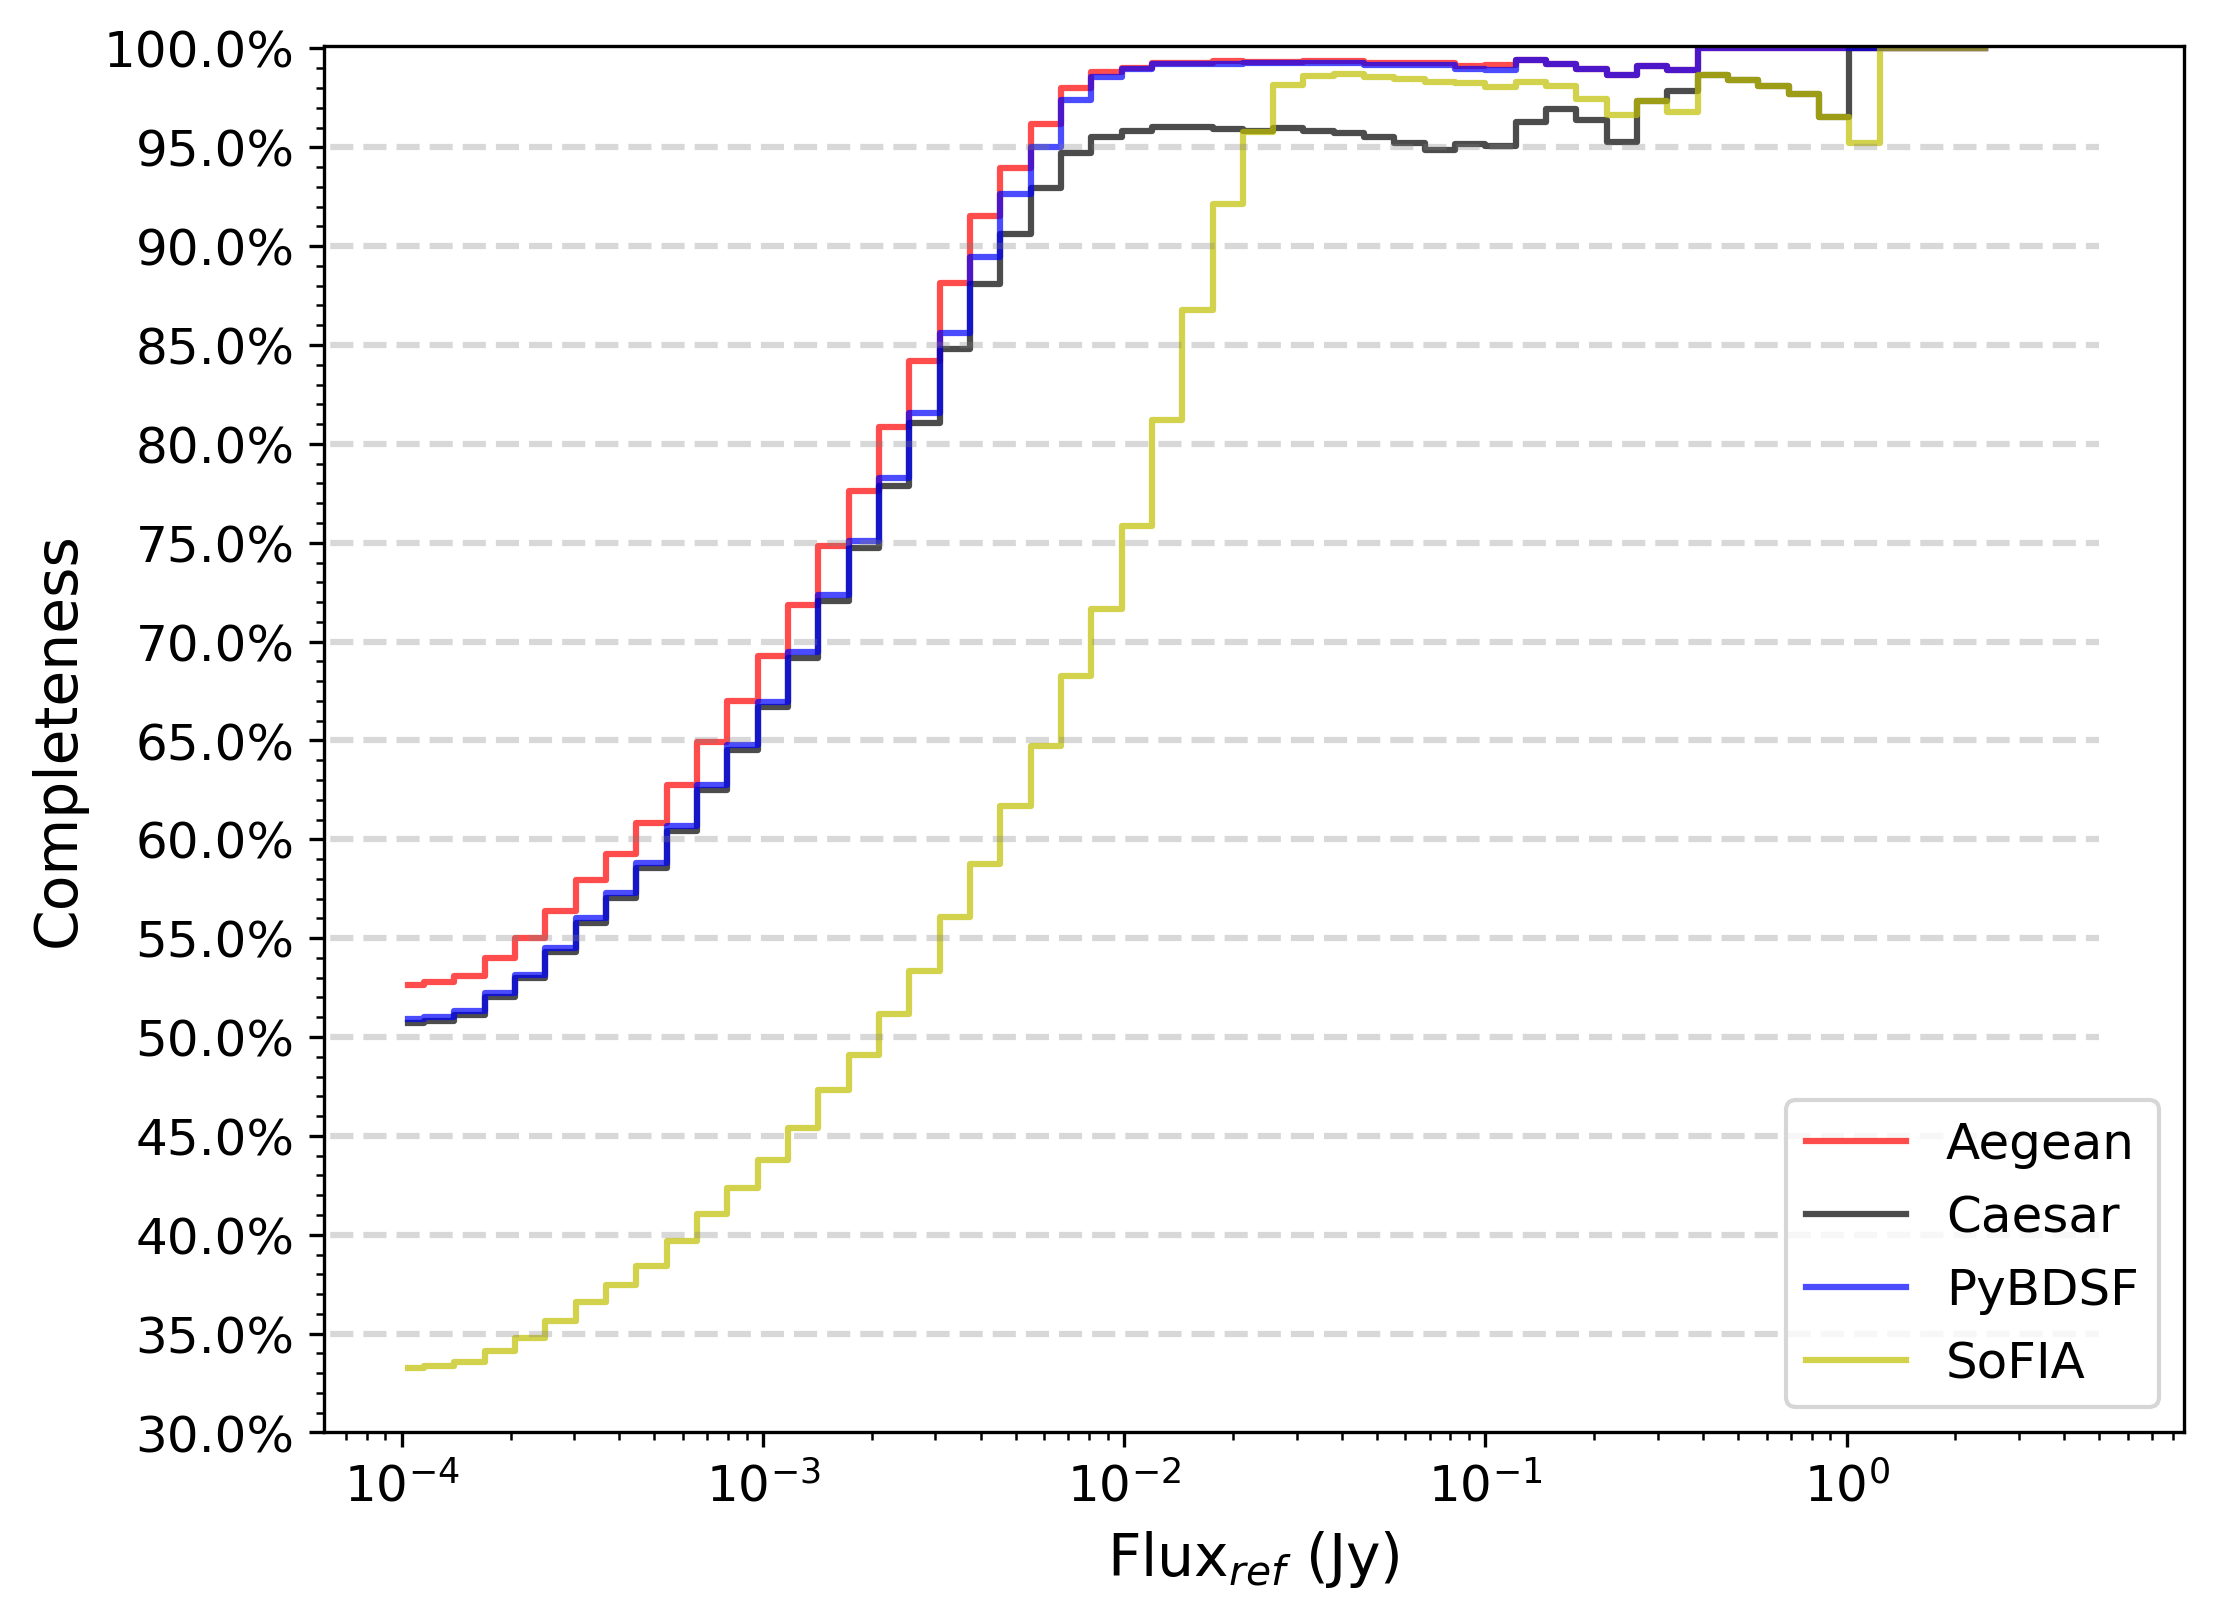

In [18]:
plot_completeness_vs_ref_flux(origs_crop, aegean_comps, caesar_comps, bdsf_comps, sofia_comps, prefix="Data-ID_1-2", match_sep=1e-5)

### 2. FDR vs. flux_test

In [19]:
def calculate_FDR_vs_test_flux(comps_ref, comps_test, match_sep=1e-5):
    
    """
    Calculate the FDR vs. test flux.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return [fluxes_plot, FDR_values]: the data to plot (FDR_values in percentage)
    
    """
    
    # match comps_ref with comps_test
    results = check_source(comps_ref, comps_test, match_sep)
    
    # get fluxes of comps_test
    output_fluxes = [comp.flux[0] for comp in comps_test]
    
    # matched comps_test
    match_test = [comps_test[match[0]] for match in results]
    
    # linspace corrspond to the log(input_fluxes)
    log_max = np.log10(min(output_fluxes))
    log_min = np.log10(max(output_fluxes)) 
    fluxes_x_log = np.linspace(log_max, log_min, len(comps_test)//80)
    
    # create FDR list
    FDR_values = []
    fluxes_plot = []
    
    
    # calculate FDR of S > S_flux
    for exp in fluxes_x_log:
        flux = 10**(exp)
#     for flux in fluxes:
        test_flux_j = [comp.flux > flux for comp in comps_test]
        # count for S > S_flux in comps_test
        N_total = test_flux_j.count(True)
        
        # count for S > S_flux in comps_match
        match_test_flux_j = [comp.flux > flux for comp in match_test]
        N_real = match_test_flux_j.count(True)
        
        if N_total != 0:
            fluxes_plot.append(flux)
            FDR_values.append(1-(N_real / N_total))
    
    # trans to percentage
    FDR_values = [value*100 for value in FDR_values]
            
    return[fluxes_plot, FDR_values]

def plot_FDR_vs_test_flux(comps_ref, comps_test1, comps_test2, comps_test3, comps_test4, prefix, match_sep=1e-5):
    
    """
    Plot FDR vs. test flux of source finders.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue, 
                            the order correspond to, 1-Aegean, 2-Caesar, 3-PyBDSF, 4-SoFIA
    :param prefix: the prefix of figure saved
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return 
    
    """
    
    # get the plot data of source finders
    values1 = calculate_FDR_vs_test_flux(comps_ref, comps_test1, match_sep=1e-5)
    values2 = calculate_FDR_vs_test_flux(comps_ref, comps_test2, match_sep=1e-5)
    values3 = calculate_FDR_vs_test_flux(comps_ref, comps_test3, match_sep=1e-5)
    values4 = calculate_FDR_vs_test_flux(comps_ref, comps_test4, match_sep=1e-5)
    
    # plot FDR vs. flux
    plt.figure(figsize=(8, 6), dpi=300)
    
    plt.step(values1[0], values1[1], color="r", alpha=0.7, where='mid', label="Aegean")
    plt.step(values2[0], values2[1], color="black", alpha=0.7, where='mid', label="Caesar")
    plt.step(values3[0], values3[1], color="b", alpha=0.7, where='mid', label="PyBDSF")
    plt.step(values4[0], values4[1], color="y", alpha=0.7, where='mid', label="SoFIA")
    
    plt.ylim(-0.1, 45)
    plt.xscale("log")
    plt.xlim(10**-3.5, 10**0.5)
    plt.xlabel('Flux$_{test}$ (Jy)', fontsize=14)
    plt.ylabel('False Detection Rate', fontsize=14)
    
    plt.yticks(np.arange(0, 50, 5), labels=['0.0', '5.0', '10.0', '15.0', '20.0', '25.0', '30.0', '35.0', '40.0', '45.0'])
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter()) 
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.minorticks_on()
    
    # plot hlines
    plt.hlines(40, 0, 5, colors='gray', linestyles='dashed', alpha=0.3) 
    plt.hlines(35, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(30, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(25, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(20, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(15, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(10, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)


    plt.legend(loc="best", fontsize=12)
    
    # savue figure
    plt.savefig(prefix + "_compare_FDR_test.png", bbox_inches='tight')
    
    plt.show()
    plt.clf()

4349 sources in and 2474 sources out
4349 sources in and 3707 sources out
4349 sources in and 3841 sources out
4349 sources in and 1493 sources out


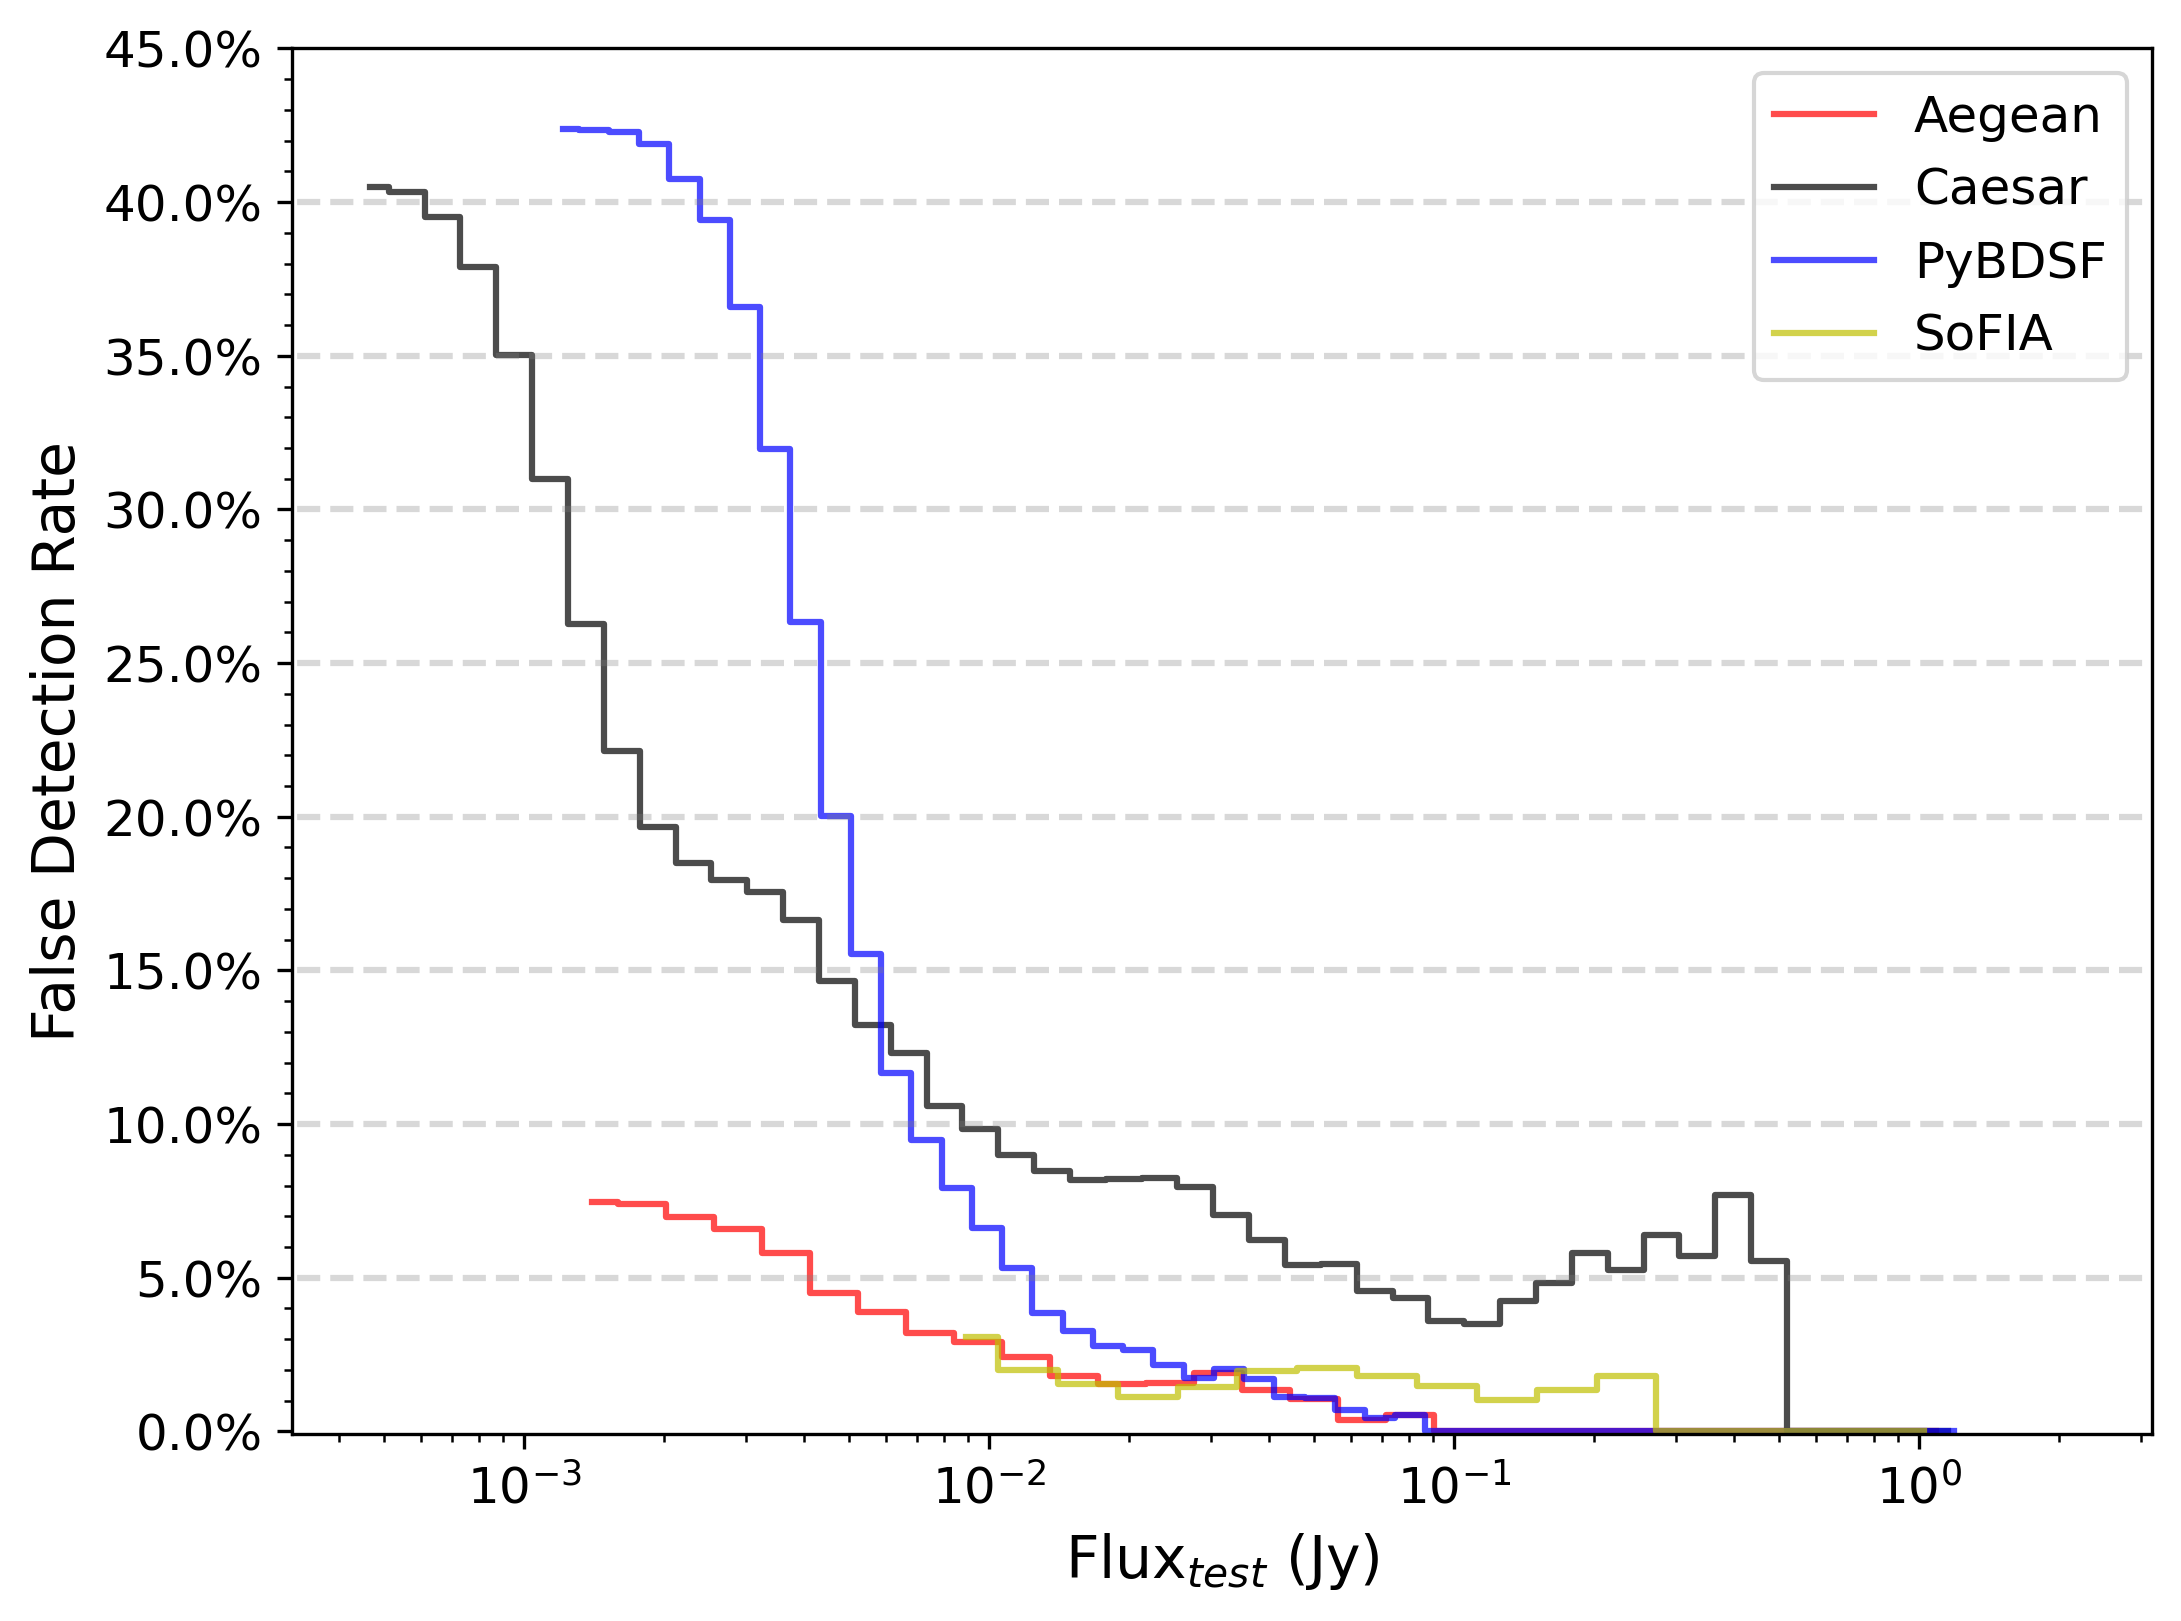

<Figure size 640x480 with 0 Axes>

In [20]:
plot_FDR_vs_test_flux(origs_crop, aegean_comps, caesar_comps, bdsf_comps, sofia_comps, prefix="Data-ID_1-2", match_sep=1e-5)

### 3. position_deviation vs. flux_ref

In [21]:
def calculate_mean_position_deviation_vs_ref_flux(comps_ref, comps_test, match_sep=1e-5, bin_per=0.05):
    "calculate mean postion deviation vs. ref flux"
    
    """
    Calculate the mean positon deviation vs. test flux in a bin of flux.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :param bin_per: the bin width
    :return [fluxes_plot, mean_positon_deviations]: the data to plot
    
    """
    
    
    # match comps_ref with comps_test
    results = check_source(comps_ref, comps_test, match_sep)
    
    match_ref = [comps_ref[match[1]] for match in results]
    match_ref_fluxes = [comp.flux[0][0] for comp in match_ref]


    log_max = np.log10(min(match_ref_fluxes))
    log_min = np.log10(max(match_ref_fluxes)) 
    fluxes_x_log = np.linspace(log_max, log_min, len(results)//80)
    
    # store values
    mean_position_deviations = []
    flux_values = []
    
    # choice the bin width for plot
    bin_width = bin_per * (max(match_ref_fluxes) - min(match_ref_fluxes))
    
    # to calculate mean separtions
    for exp in fluxes_x_log:
        flux = 10**(exp)
        # the range in the bin of flux        
        flux_range = (flux-1/2*bin_width, flux+1/2*bin_width)
        position_deviations = []

        for match in results:                
            match_ref_flux = comps_ref[match[1]].flux[0][0]
            
            if match_ref_flux >= flux_range[0] and match_ref_flux < flux_range[1]:
                
                position_deviations.append(match[2])
        
        # if have the values in the bin
        if isinstance(np.mean(position_deviations), float):
            flux_values.append(flux)
            # rad to arcsec
            mean_position_deviations.append(np.mean(position_deviations) * (180*3600 / math.pi))
            

    return [flux_values, mean_position_deviations]

def plot_mean_positon_deviation_vs_ref_flux(comps_ref, comps_test1, comps_test2, comps_test3, comps_test4, prefix, match_sep=1e-5):
    
    """
    Plot mean position deviation vs. test flux of source finders.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue, 
                            the order correspond to, 1-Aegean, 2-Caesar, 3-PyBDSF, 4-SoFIA
    :param prefix: the prefix of figure saved
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return 
    
    """
    
    # get the plot data of source finders
    values1 = calculate_mean_position_deviation_vs_ref_flux(comps_ref, comps_test1, match_sep=1e-5, bin_per=0.05)
    values2 = calculate_mean_position_deviation_vs_ref_flux(comps_ref, comps_test2, match_sep=1e-5, bin_per=0.05)
    values3 = calculate_mean_position_deviation_vs_ref_flux(comps_ref, comps_test3, match_sep=1e-5, bin_per=0.05)
    values4 = calculate_mean_position_deviation_vs_ref_flux(comps_ref, comps_test4, match_sep=1e-5, bin_per=0.05)
    
    # plot mean position deviation vs. flux
    plt.figure(figsize=(8, 6), dpi=300)

    plt.step(values1[0], values1[1], color="r", alpha=0.7, where='mid', label="Aegean")
    plt.step(values2[0], values2[1], color="black", alpha=0.7, where='mid', label="Caesar")
    plt.step(values3[0], values3[1], color="b", alpha=0.7, where='mid', label="PyBDSF")
    plt.step(values4[0], values4[1], color="y", alpha=0.7, where='mid', label="SoFIA")

    plt.xscale("log")
    plt.xlabel('Flux$_{ref}$ (Jy)', fontsize=14)
    plt.xlim(right=10**0.6)
    plt.ylim(0, 0.5)
    plt.ylabel('Mean Position Deviation (arcsec)', fontsize=14)
        
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(np.arange(0, 0.55, 0.05), labels=['0', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45', '0.50']) 

    plt.minorticks_on()
    
    # plot hlines
    plt.hlines(0.45, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.4, 0, 5, colors='gray', linestyles='dashed', alpha=0.3) 
    plt.hlines(0.35, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.3, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.25, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.2, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.15, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.1, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(0.05, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)

    plt.legend(loc="upper right", fontsize=12)
    
    # save figure
    plt.savefig(prefix + "_compare_Mean_separation.png", bbox_inches='tight')
    
    plt.show()
    plt.clf()

4349 sources in and 2474 sources out
4349 sources in and 3707 sources out


/home/wushaofeng/envs/rascil2_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wushaofeng/envs/rascil2_env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4349 sources in and 3841 sources out
4349 sources in and 1493 sources out


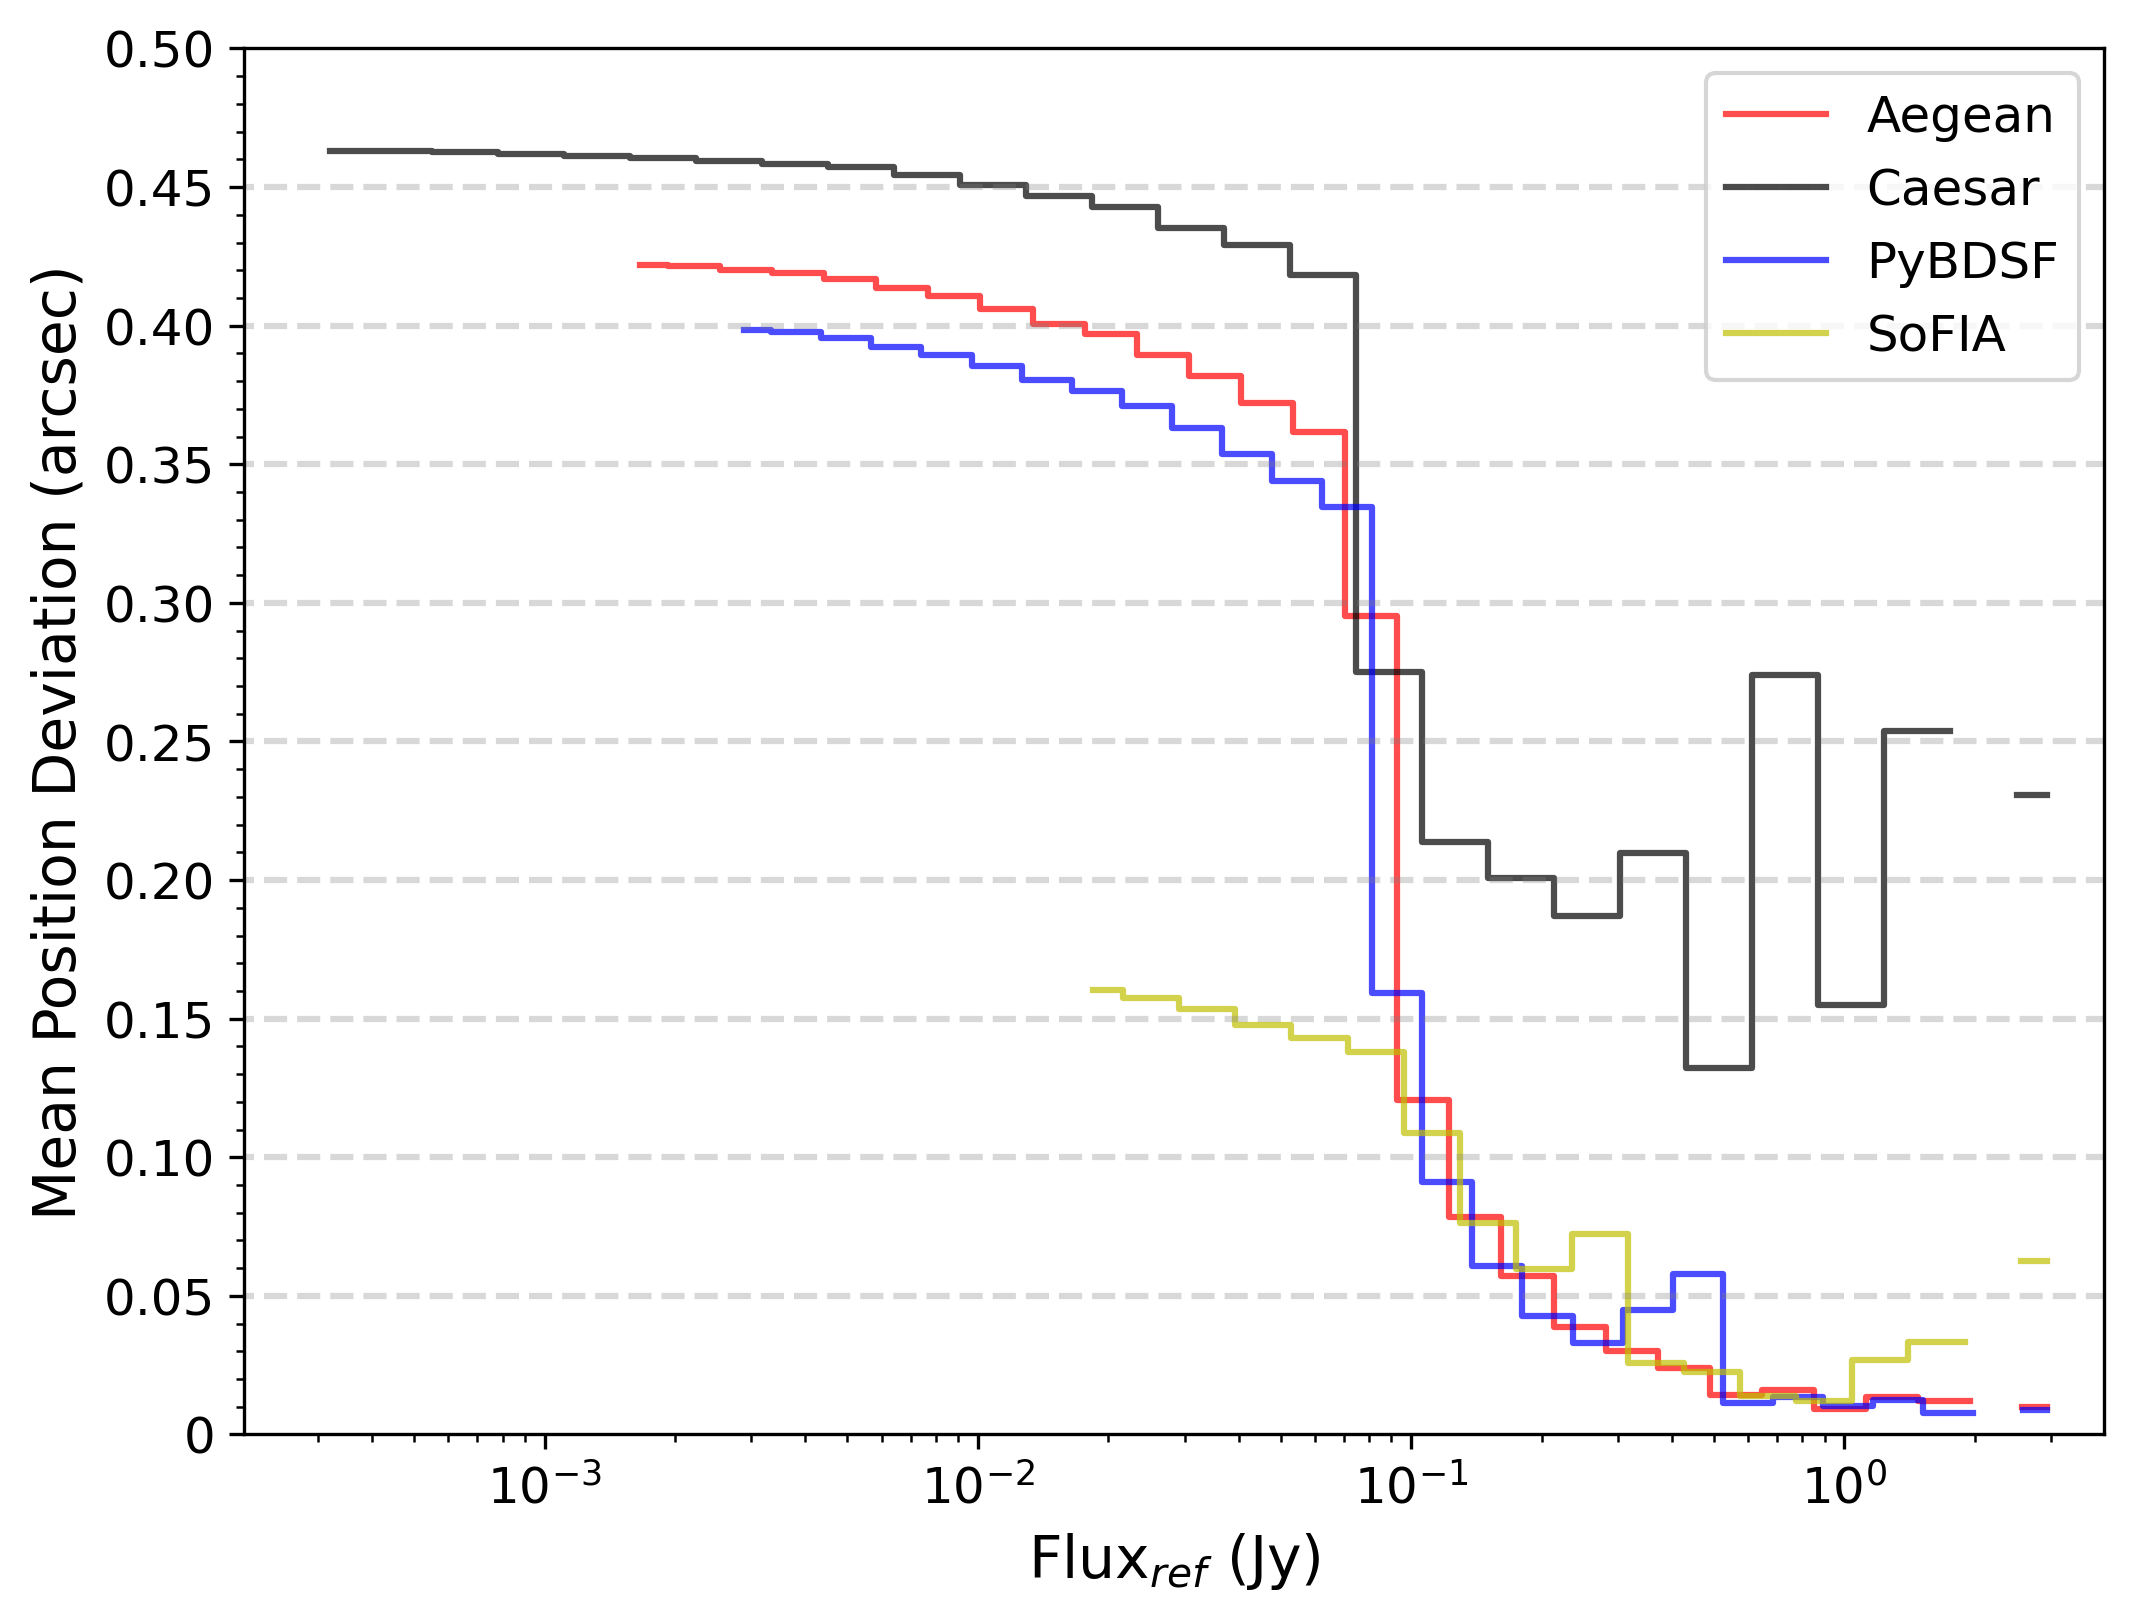

<Figure size 640x480 with 0 Axes>

In [22]:
plot_mean_positon_deviation_vs_ref_flux(origs_crop, aegean_comps, caesar_comps, bdsf_comps, sofia_comps, prefix="Data-ID_1-2", match_sep=1e-5)

### 4. flux_ratio(test/ref) vs. flux_ref

In [23]:
def calculate_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test, match_sep=1e-5, bin_per=0.05):
    """
    Calculate the mean flux ratio vs. ref flux in bins of flux.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :param bin_per: the bin width
    :return [fluxes_plot, mean_flux_ratio]: the data to plot (mean_flux_ratio in percentage)
    
    """
    
    # match comps_ref with comps_test
    results = check_source(comps_ref, comps_test, match_sep)
    
    # match comps_ref with comps_test
    results = check_source(comps_ref, comps_test, match_sep)
    
    match_ref = [comps_ref[match[1]] for match in results]
    match_ref_fluxes = [comp.flux[0][0] for comp in match_ref]


    log_max = np.log10(min(match_ref_fluxes))
    log_min = np.log10(max(match_ref_fluxes)) 
    fluxes_x_log = np.linspace(log_max, log_min, len(results)//80)
    
    # store values
    mean_flux_ratios = []
    flux_values = []
    
    # choice the bin width for plot
    bin_width = bin_per * (max(match_ref_fluxes) - min(match_ref_fluxes))
    
    # to calculate mean flux ratios
    for exp in fluxes_x_log:
        flux = 10**(exp)
                
        flux_range = (flux-1/2*bin_width, flux+1/2*bin_width)
        flux_ratios = []

        for match in results:
            match_ref_flux = comps_ref[match[1]].flux[0]
            match_test_flux = comps_test[match[0]].flux[0]

            # if the ref flux in bin
            if match_ref_flux >= flux_range[0] and match_ref_flux < flux_range[1]:
                
                flux_ratio = match_test_flux / match_ref_flux
                flux_ratios.append(flux_ratio)
                
        # if have value in the bin
        if isinstance(np.mean(flux_ratios), float):
            flux_values.append(flux)
            mean_flux_ratios.append(np.mean(flux_ratios))

    # trans to percentage    
    mean_flux_ratios = [value*100 for value in mean_flux_ratios]
    
    return [flux_values, mean_flux_ratios]

def plot_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test1, comps_test2, comps_test3, comps_test4, prefix, match_sep=1e-5):
    
    """
    Plot mean flux ratio vs. test flux of source finders.
    
    :param comps_ref: the source list of the reference catalogue
    :param comps_test: the source list of the test catalogue, 
                            the order correspond to, 1-Aegean, 2-Caesar, 3-PyBDSF, 4-SoFIA
    :param prefix: the prefix of figure saved
    :param match_sep: the threshold to match sources between two catalogues (in rad)
    :return 
    
    """
    
    # get the plot data of source finders
    values1 = calculate_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test1, match_sep=1e-5, bin_per=0.1)
    values2 = calculate_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test2, match_sep=1e-5, bin_per=0.1)
    values3 = calculate_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test3, match_sep=1e-5, bin_per=0.1)
    values4 = calculate_mean_flux_ratio_vs_ref_flux(comps_ref, comps_test4, match_sep=1e-5, bin_per=0.1)

    # plot mean flux_ratio vs. flux_ref
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300) 
    
    plt.step(values1[0], values1[1], color="r", alpha=0.7, where='mid', label="Aegean")
    plt.step(values2[0], values2[1], color="black", alpha=0.7, where='mid', label="Caesar")
    plt.step(values3[0], values3[1], color="b", alpha=0.7, where='mid', label="PyBDSF")
    plt.step(values4[0], values4[1], color="y", alpha=0.7, where='mid', label="SoFIA")
    
    plt.xscale("log")
    plt.xlabel('Flux$_{ref}$ (Jy)', fontsize=14)
    plt.xlim(10**-4, 10**0.6)
    plt.ylim(38, 45)
    plt.ylabel('Mean Flux Ratio (test/reference)', fontsize=14)
    
    plt.yticks(np.arange(38, 45.5, 0.5), labels=['38', '38.5', '39.0', '39.5', '40', '40.5', '41.0', '41.5', '42.0', '42.5', '43.0', '43.5', '44.0', '44.5', '45.0'])
    
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter()) 
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=10)
    plt.minorticks_on()
    
    # plot hlines
    plt.hlines(44.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(44, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(43.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(43, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(42.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(42, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(41.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(41, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(40.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(40, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(39.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(39, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)
    plt.hlines(38.5, 0, 5, colors='gray', linestyles='dashed', alpha=0.3)

    plt.legend(loc="upper left", fontsize=12)
    
    fig.savefig(prefix + "_compare_mean_flux_ratio.png", bbox_inches='tight')

    plt.show()
    plt.clf()

4349 sources in and 2474 sources out
4349 sources in and 2474 sources out
4349 sources in and 3707 sources out
4349 sources in and 3707 sources out
4349 sources in and 3841 sources out
4349 sources in and 3841 sources out
4349 sources in and 1493 sources out
4349 sources in and 1493 sources out


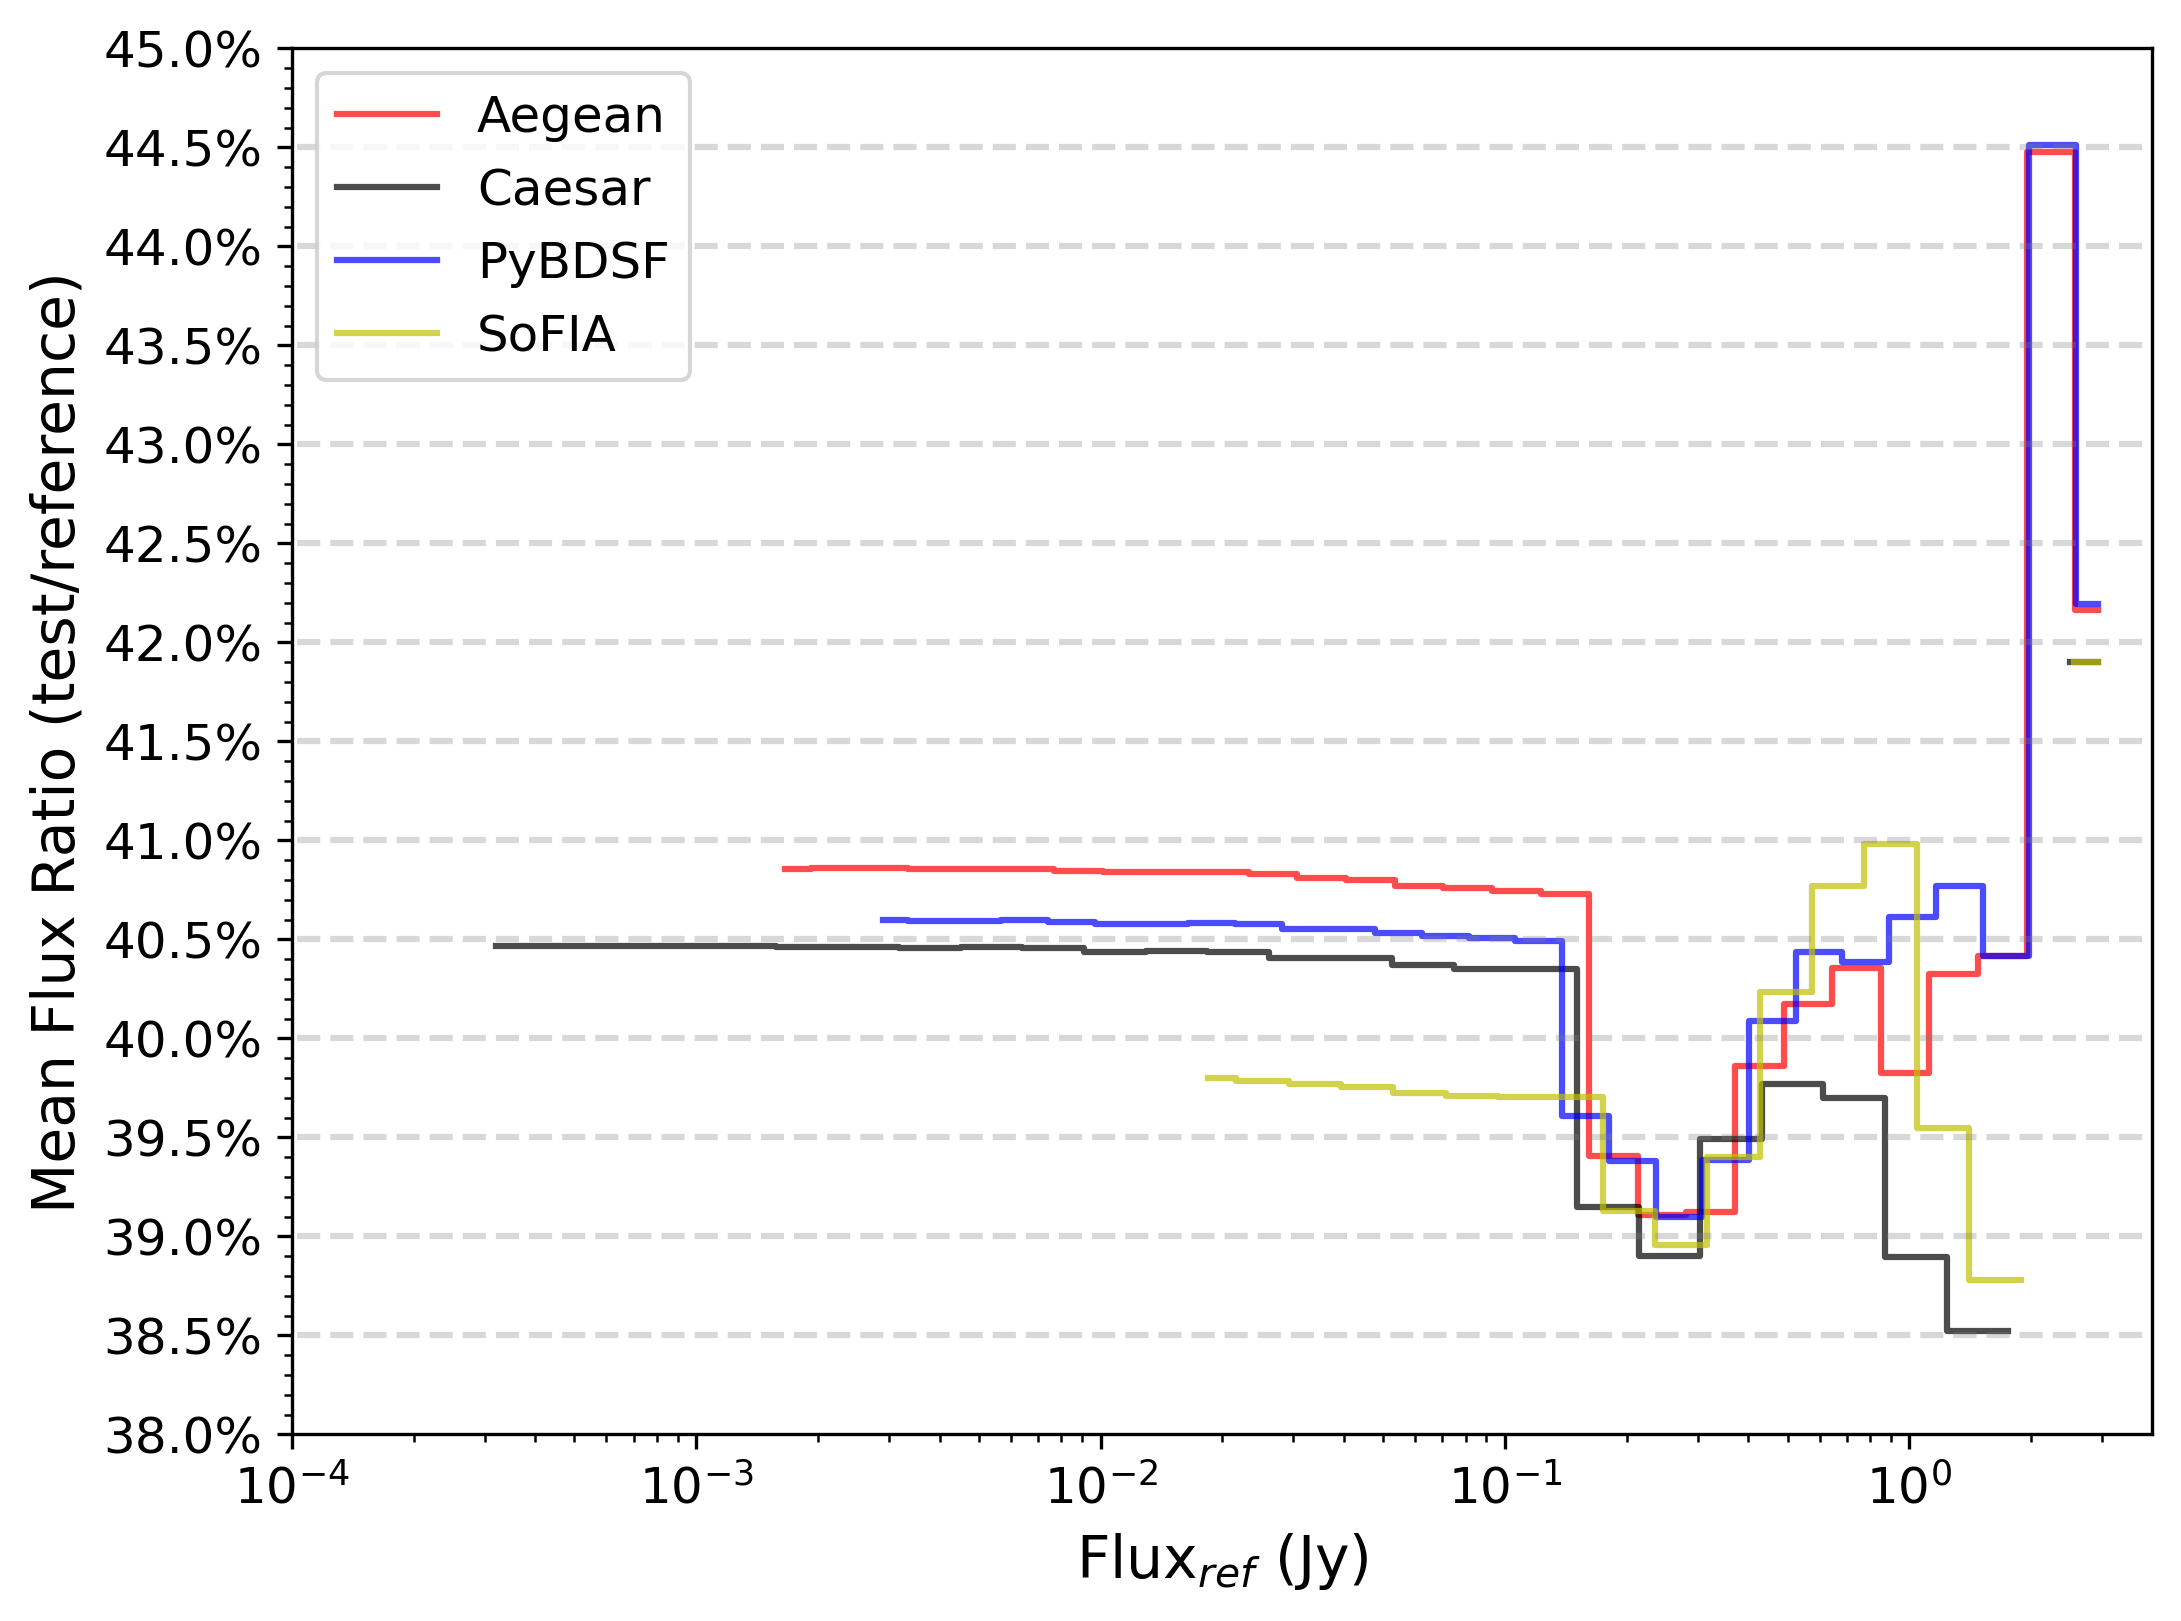

<Figure size 640x480 with 0 Axes>

In [24]:
plot_mean_flux_ratio_vs_ref_flux(origs_crop, aegean_comps, caesar_comps, bdsf_comps, sofia_comps, prefix="Data-ID_1-2", match_sep=1e-5)

## comparisions between adopting Aegean and PyBDSF (original QA) as the source finder

### 1. position error

In [25]:
def plot_skycomponents_position_errors(
    comps_test1,
    comps_test2,
    comps_ref,
    img_size=1.0,
    plot_file=None,
    tol=1e-5,
    plot_error=True
):
    """Generate position scatter plot for two lists of skycomponents

    :param comps_test: List of components to be tested,
                        the order correspond to, 1-PyBDSF, 2-Aegean
    :param img_size: Cell size per pixel in the image to compare
    :param comps_ref: List of reference components
    :param plot_file: Filename of the plot
    :param tol: Tolerance in rad
    :param plot_error : If True, plot error, else just plot absolute values
    :return: [ra_error, dec_error]:
             The error array for users to check
    """
    # This wraps the angles larger than 180 degrees to (-180, 180]
    angle_wrap = 180.0 * u.deg

    # If the angle values cross over -180 OR 180 degrees, don't apply wrapping
    # Input a list of astropy Angle object
    def unwrap_around_180(angles):

        angles_degree = [angle.degree for angle in angles]
        if (
            max(angles_degree) > 180.0
            and max(angles_degree) < 270.0
            and min(angles_degree) < 180.0
            and min(angles_degree) > 90.0
        ) or (
            max(angles_degree) > -180.0
            and max(angles_degree) < -90.0
            and min(angles_degree) < -180.0
            and min(angles_degree) > -270.0
        ):
            return np.array(angles_degree)
        else:
            log.info("Wrap angles to (-180, 180]")
            wrap = [angle.wrap_at(angle_wrap).degree for angle in angles]
            return np.array(wrap)
        
    def calculate_position_error(comps_test, comps_ref, tol=1e-5, img_size=1.0):

        matches = find_skycomponent_matches(comps_test, comps_ref, tol)
        ra_test = [None] * len(matches)
        dec_test = np.zeros(len(matches))
        ra_ref = [None] * len(matches)
        dec_ref = np.zeros(len(matches))
        ra_error = np.zeros(len(matches))
        dec_error = np.zeros(len(matches))
        for i, match in enumerate(matches):
            m_comp = comps_test[match[0]]
            ra_test[i] = m_comp.direction.ra
            dec_test[i] = m_comp.direction.dec.degree
            m_ref = comps_ref[match[1]]
            ra_ref[i] = m_ref.direction.ra
            dec_ref[i] = m_ref.direction.dec.degree

            if img_size > 0.0:
                ra_error[i] = (
                    (
                        m_comp.direction.ra.wrap_at(angle_wrap).degree
                        - m_ref.direction.ra.wrap_at(angle_wrap).degree
                    )
                    * np.cos(m_ref.direction.dec.rad)
                    / img_size
                )

                dec_error[i] = (
                    m_comp.direction.dec.degree - m_ref.direction.dec.degree
                ) / img_size

            else:
                log.info("Wrong input image resolution. Plot absolute values instead.")
                ra_error[i] = (
                    m_comp.direction.ra.wrap_at(angle_wrap).degree
                    - m_ref.direction.ra.wrap_at(angle_wrap).degree
                ) * np.cos(m_ref.direction.dec.rad)

                dec_error[i] = m_comp.direction.dec.degree - m_ref.direction.dec.degree
                
        return [ra_error, dec_error]
    
    # calculate position error
    error1 = calculate_position_error(comps_test1, comps_ref, img_size=img_size)
    error2 = calculate_position_error(comps_test2, comps_ref, img_size=img_size)


    plt.figure(dpi=300)
    ax = plt.gca()
    ax.set_aspect(1.0)
    ax.plot(error1[0], error1[1], "o", markersize=3, c="b", alpha=0.7, label="PyBDSF")
    ax.plot(error2[0], error2[1], "o", markersize=3, c="r", alpha=0.5, label="Aegean")


    plt.xlabel(r"$\Delta\ RA * cos(Dec) / \Delta x$", fontsize=14)
    plt.ylabel(r"$\Delta\ Dec/ \Delta x$", fontsize=14)
    plt.title("Errors in RA and Dec", fontsize=14)
    plt.legend(loc="best")
    
    plt.savefig(plot_file + "_position_error.png")
    
    plt.show()
    plt.clf()

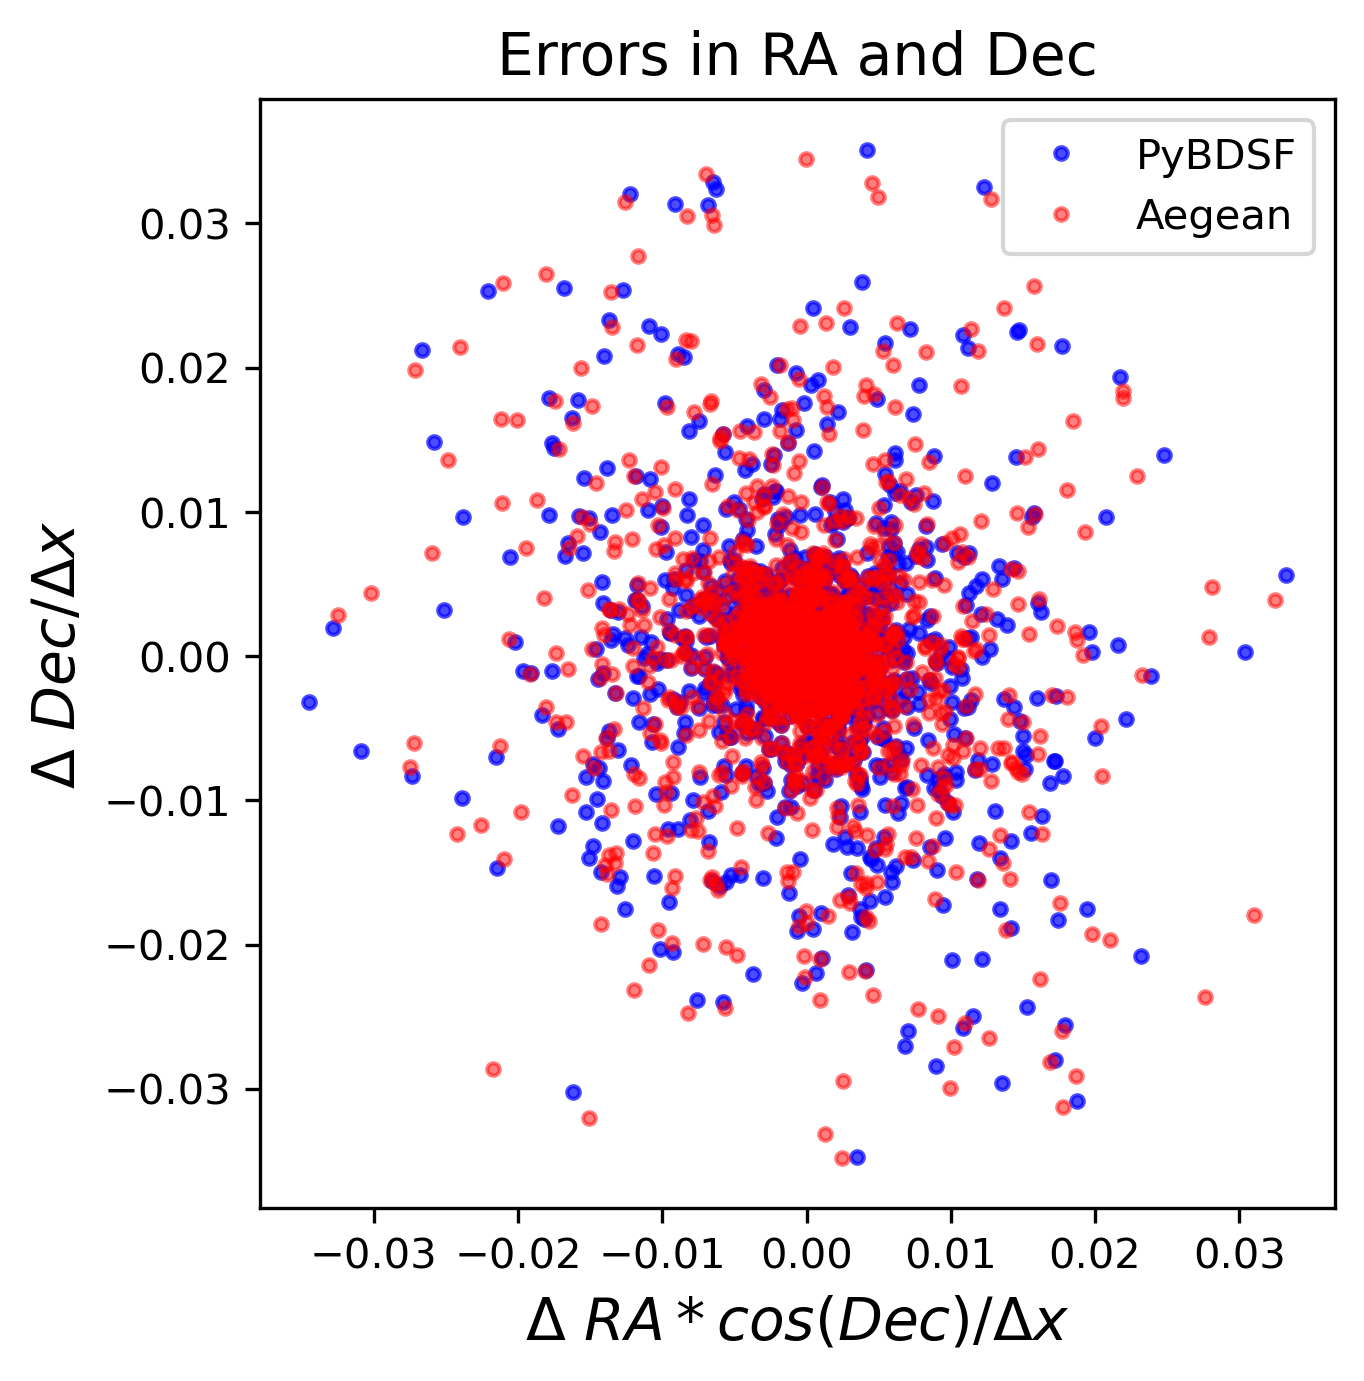

<Figure size 640x480 with 0 Axes>

In [26]:
plot_skycomponents_position_errors(bdsf_comps, aegean_comps, origs_crop, img_size, plot_file='Data-ID_1-2_bdsf_aegean')

### 2. flux ratio

In [27]:
def plot_skycomponents_flux_ratio(
    comps_test1,
    comps_test2,
    comps_ref,
    phasecentre,
    plot_file=None,
    tol=1e-5,
    refchan=None,
    max_ratio=2,
    **kwargs,
):

    """Generate flux ratio plot vs distance for two lists of skycomponents

    :param comps_test: List of components to be tested，
                        the order correspond to, 1-PyBDSF, 2-Aegean
    :param comps_ref: List of reference components
    :param plot_file: Filename of the plot
    :param tol: Tolerance in rad
    :param phasecentre: Centre of image in SkyCoords
    :param refchan: Reference channel for comparison, default is centre channel
    :param max_ratio: Maximum ratio to plot (default is 2.0)
    :return: [dist, flux_ratio]:
             The flux array for users to check
    """
    
    def get_flux_ratios_dists(comps_test, comps_ref, phasecentre, tol, refchan, max_ratio):
        
        angle_wrap = 180.0 * u.deg

        matches = find_skycomponent_matches(comps_test, comps_ref, tol)
        flux_ratio = []
        dist = []
        ra = []
        dec = []

        for i, match in enumerate(matches):
            m_comp = comps_test[match[0]]
            m_ref = comps_ref[match[1]]

            # Take the first polarisation
            if refchan is None:
                nchan, _ = m_ref.flux.shape
                if m_ref.flux[nchan // 2, 0] > 0.0:
                    fr = m_comp.flux[nchan // 2, 0] / m_ref.flux[nchan // 2, 0]
            else:
                if m_ref.flux[refchan, 0] > 0.0:
                    fr = m_comp.flux[refchan, 0] / m_ref.flux[refchan, 0]

            if fr > 0.0 and fr < max_ratio:
                flux_ratio.append(fr)
                dist.append(m_comp.direction.separation(phasecentre).degree)
                ra.append(m_comp.direction.ra.wrap_at(angle_wrap).degree)
                dec.append(m_comp.direction.dec.degree)

        if len(dist) == 0:
            raise ValueError("No valid points found for flux ratio plot")
            
        return[flux_ratio, dist, ra, dec]
    
    values1 = get_flux_ratios_dists(comps_test1, comps_ref, phasecentre, tol, refchan, max_ratio)
    values2 = get_flux_ratios_dists(comps_test2, comps_ref, phasecentre, tol, refchan, max_ratio)

    plt.figure(dpi=300)
    plt.plot(values1[1], values1[0], "o", color="b", markersize=3, alpha=0.7, label='PyBDSF')
    plt.plot(values2[1], values2[0], "o", color="r", markersize=3, alpha=0.4, label='Aegean')


    plt.title("Flux ratio vs. distance", fontsize=14)
    plt.xlabel("Distance to center (Deg)", fontsize=14)
    plt.ylabel("Flux Ratio (Out/In)", fontsize=14)
    plt.legend(loc='best')

    plt.savefig(plot_file + "_flux_ratio.png")

    plt.show()
    plt.clf()


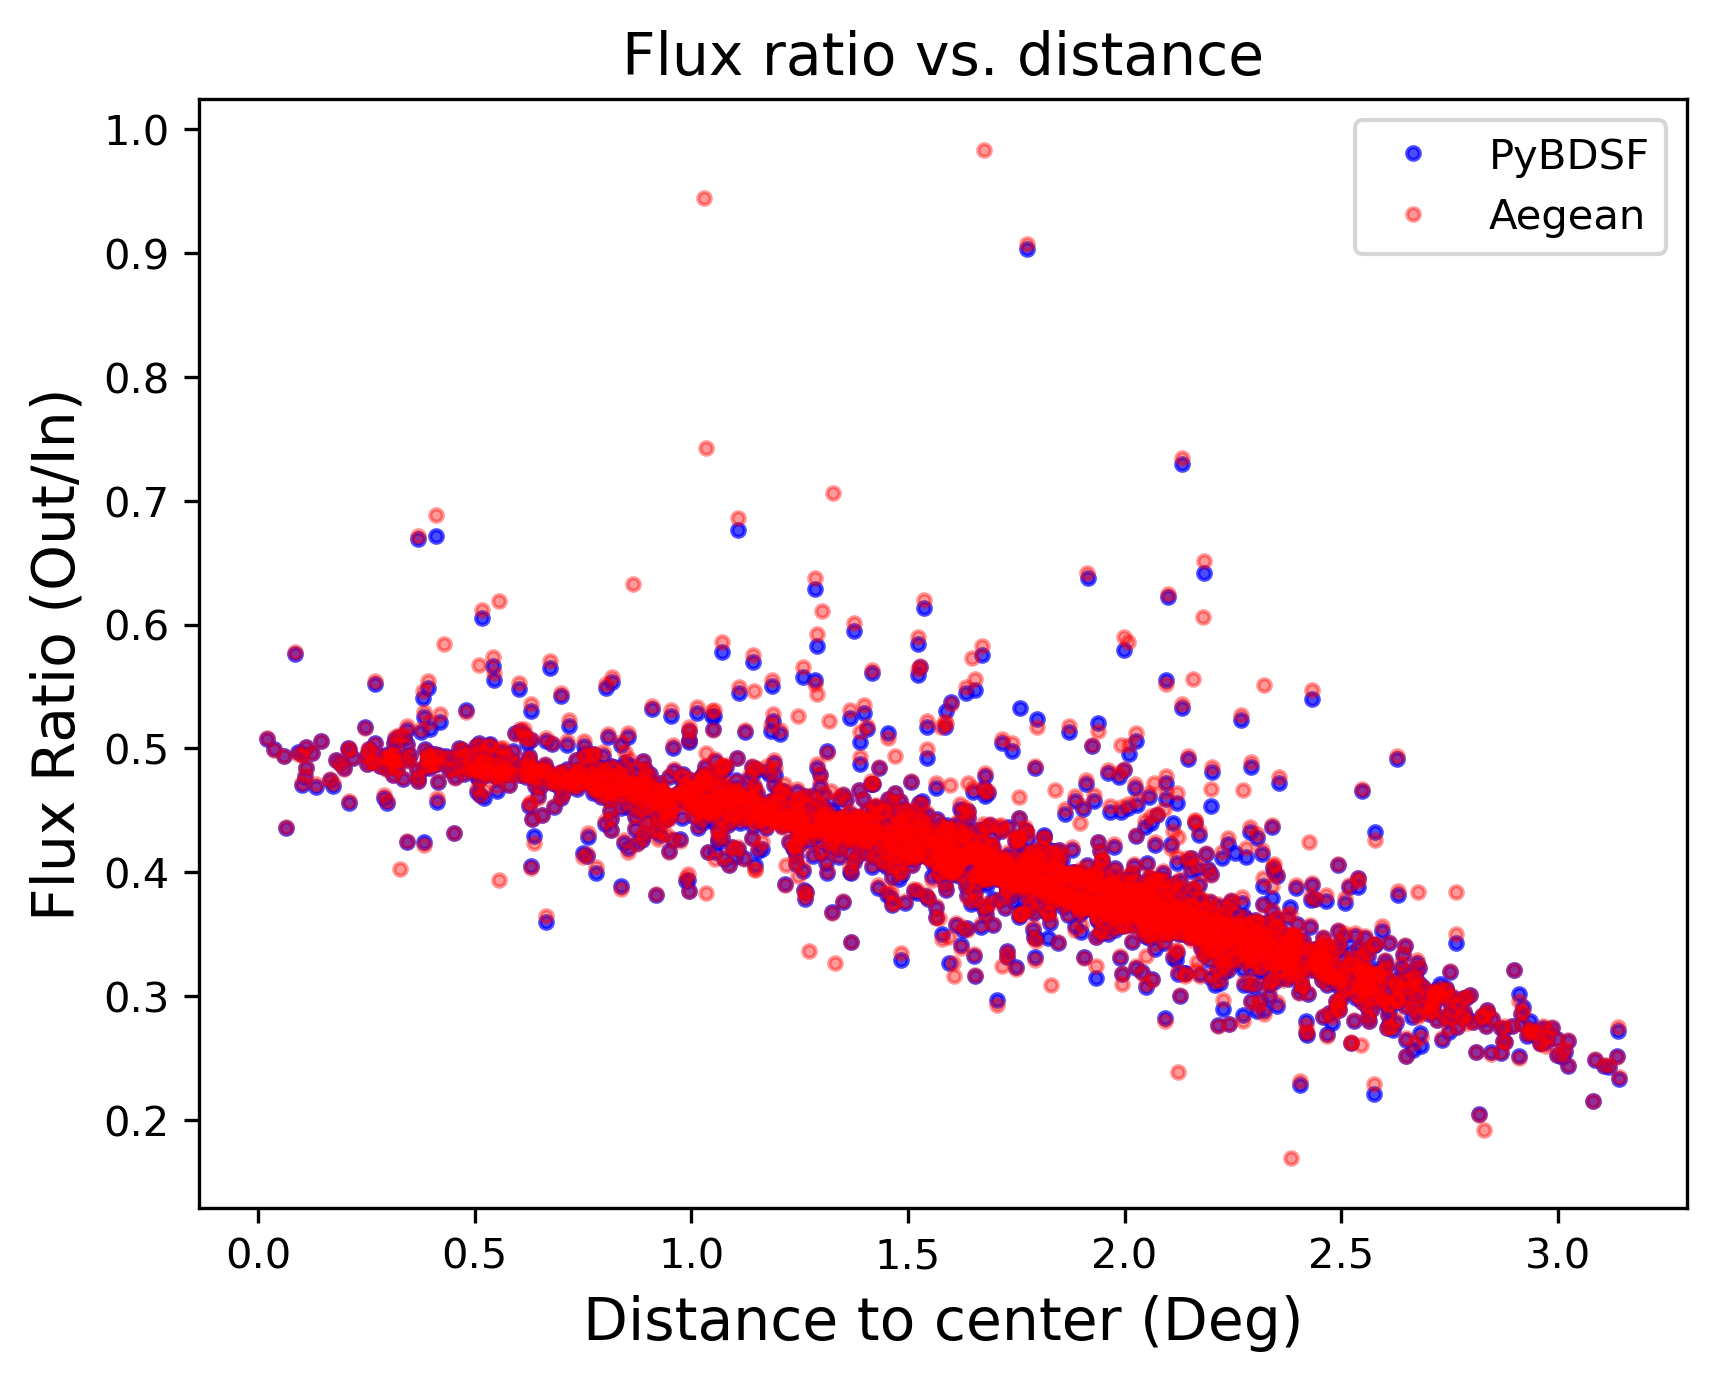

<Figure size 640x480 with 0 Axes>

In [28]:
plot_skycomponents_flux_ratio(bdsf_comps, aegean_comps, origs_crop, phasecentre, plot_file='Data-ID_1-2_bdsf_aegean', 
                                  tol=1e-5, efchan=None, max_ratio=2)